In [1]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.stats as stats
import pickle
import optuna

In [2]:
# 時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [3]:
datePrint("loading input_test")
input_test = pickle.load(open("../data/access_len5_100base/input_test.pkl","rb"))

datePrint("loading target_test")
target_test = pickle.load(open("../data/access_len5_100base/target_test.pkl","rb"))

datePrint("loading input_train")
input_train = pickle.load(open("../data/access_len5_100base/input_train.pkl","rb"))

datePrint("loading target_train")
target_train = pickle.load(open("../data/access_len5_100base/target_train.pkl","rb"))


[2020/10/06 15:50:17] loading input_test
[2020/10/06 15:50:17] loading target_test
[2020/10/06 15:50:17] loading input_train
[2020/10/06 15:50:18] loading target_train


In [4]:
print(input_test.shape)
print(target_test.shape)
print(input_train.shape)
print(target_train.shape)

torch.Size([100000, 4, 100])
torch.Size([100000, 96])
torch.Size([500000, 4, 100])
torch.Size([500000, 96])


In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data
        self.target = target
   
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        out_data = self.data[index]
        out_target = self.target[index]
        
        return out_data, out_target

In [6]:
optuna.logging.disable_default_handler()
class Net(nn.Module):
    def __init__(self, trial, num_layer, num_filters, kernel_sizes):
        super(Net, self).__init__()
        self.activation = F.relu
        self.conv_first = nn.Conv1d(in_channels=4, out_channels=num_filters[0] ,kernel_size=9)
        self.encoder = nn.ModuleList([])
        for i in range(1, num_layer):
            self.encoder.append(nn.Conv1d(in_channels=num_filters[i-1], out_channels=num_filters[i] ,kernel_size=kernel_sizes[i-1]))
            self.encoder.append(nn.BatchNorm1d(num_filters[i]))
        self.decoder = nn.ModuleList([])
        for i in reversed(range(1, num_layer)):
            self.decoder.append(nn.ConvTranspose1d(in_channels=num_filters[i], out_channels=num_filters[i-1] ,kernel_size=kernel_sizes[i-1]))
            self.decoder.append(nn.BatchNorm1d(num_filters[i-1]))
        self.conv_last = nn.ConvTranspose1d(in_channels=num_filters[0], out_channels=1 ,kernel_size=5)

    def forward(self, x):
        x = self.activation(self.conv_first(x))
        #x_input = x.clone()
        for i, c in enumerate(self.encoder):
            x = c(x)
            if(i%2==1):
                x = self.activation(x)
        #x = x + x_input
        #x_input = x.clone()
        for i, c in enumerate(self.decoder):
            x = c(x)
            if(i%2==1):
                x = self.activation(x)
        #x = x + x_input
        x = self.conv_last(x)
        x = x.view(x.shape[0], -1)
        return x

In [7]:
def train(model, device, train_loader, optimizer):
    criterion = nn.MSELoss().cuda()
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader)
    #train_loss_list.append(avg_train_loss)

def test(model, device, test_loader):
    criterion = nn.MSELoss().cuda()
    val_loss = 0
    model.eval()
    data_all = []
    target_all = []
    output_all = []
    loss_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            for i in range(len(target)):
                data_all.append(data[i].cpu().numpy())
                target_all.append(target[i].cpu().numpy())
                output_all.append(output[i].cpu().numpy())
                loss_list.append(criterion(output[i], target[i]).item())
            loss = criterion(output, target)
            val_loss += loss.item()
            avg_val_loss = val_loss / len(test_loader)
        #val_loss_list.append(avg_val_loss)
        
    return avg_val_loss, data_all, target_all, output_all, loss_list

In [8]:
'''
def get_activation(trial):
    activation_names = ['ReLU', 'Leaky_ReLU']
    activation_name = trial.suggest_categorical('activation', activation_names)
    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.leaky_relu
    return activation
'''

"\ndef get_activation(trial):\n    activation_names = ['ReLU', 'Leaky_ReLU']\n    activation_name = trial.suggest_categorical('activation', activation_names)\n    if activation_name == activation_names[0]:\n        activation = F.relu\n    else:\n        activation = F.leaky_relu\n    return activation\n"

In [9]:
def get_optimizer(trial, model):
    optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    if optimizer_name == optimizer_names[0]: 
        adam_lr = trial.suggest_loguniform('adam_lr', 1e-7, 1e-2)
        optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
    elif optimizer_name == optimizer_names[1]:
        momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-7, 1e-2)
        optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters())
    return optimizer

In [10]:
epoch = 10
def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    #畳み込み層の数
    num_layer = trial.suggest_int('num_layer', 1, 10)
    
    #FC層のユニット数
    #mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 500, 100))

    #各畳込み層のフィルタ数
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 192, 16)) for i in range(num_layer)]
    #各畳み込み層のカーネルサイズ
    kernel_sizes = [int(trial.suggest_discrete_uniform("kernel_size_"+str(i), 3, 9, 2)) for i in range(num_layer-1)]

    model = Net(trial, num_layer, num_filters, kernel_sizes).to(device)
    optimizer = get_optimizer(trial, model)
    #optimizer = optim.SGD(model.parameters(), lr=8e-3, momentum=0.9, weight_decay=8e-9)
    

    for step in tqdm(range(epoch)):
        train(model, device, train_loader, optimizer)
        avg_val_loss, data_all, target_all, output_all, loss_list = test(model, device, test_loader)
    
    print('test_loss: {:.3f}'.format(avg_val_loss))
    plt.figure(figsize=(7, 7), dpi=70)
    plt.scatter(target_all, output_all, s=0.1, c='yellow', marker='.')
    plt.xlim(0, 15)
    plt.ylim(-0.5, 15)
    plt.xlabel('target')
    plt.ylabel('output')
    plt.show()
    
    cor_list = []
    for n in range(len(target_all)):
        cor = np.corrcoef(target_all[n], output_all[n])
        cor_list.append(cor[0, 1])
    plt.hist(cor_list)
    plt.xlabel('correlation coefficient')
    plt.ylabel('count')
    plt.show()
    print(np.average(cor_list))

    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(cor_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(cor_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.title('cor_max')
    plt.show()

    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(cor_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(cor_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.title('cor_min')
    plt.show()

    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(loss_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(loss_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.title('loss_max')
    plt.show()

    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(loss_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(loss_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.title('loss_min')
    plt.show()
    
    return avg_val_loss


test_loss: 2.544


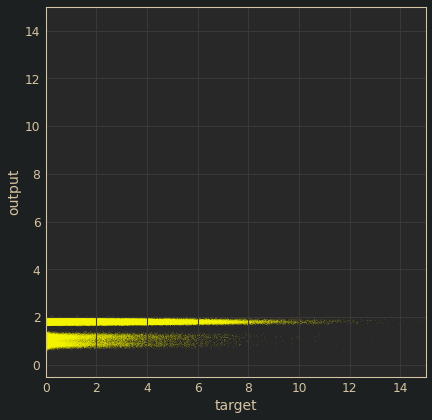

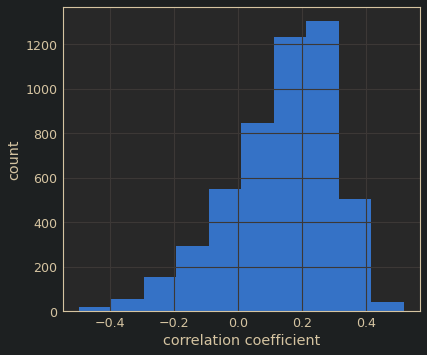

0.13497783515782677


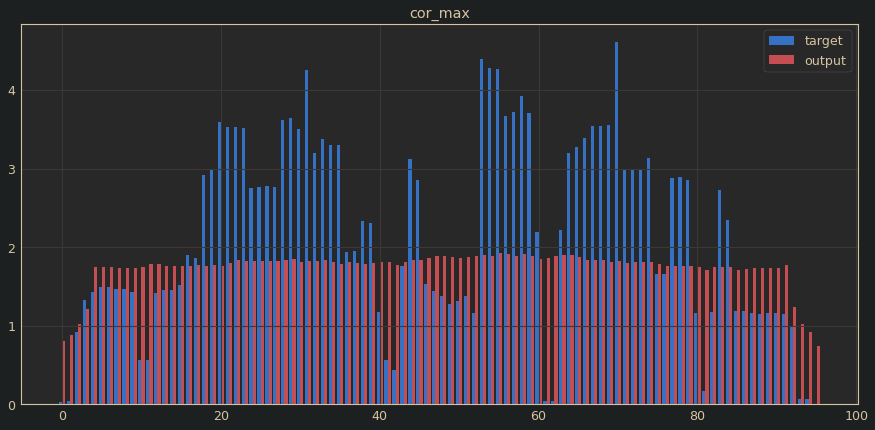

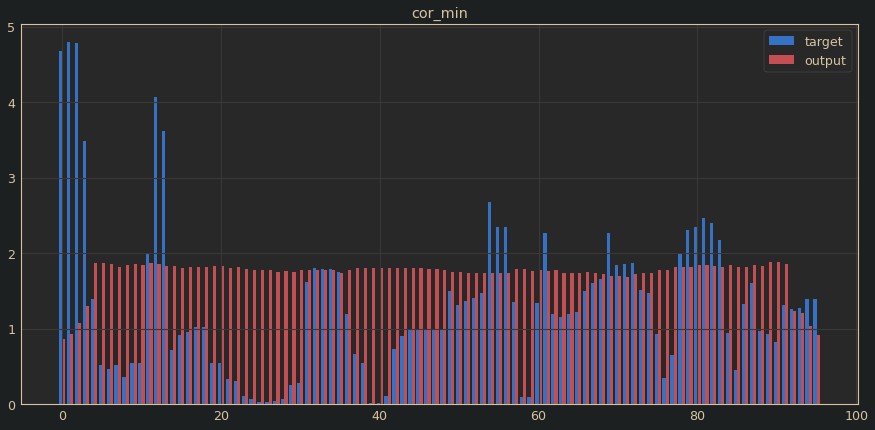

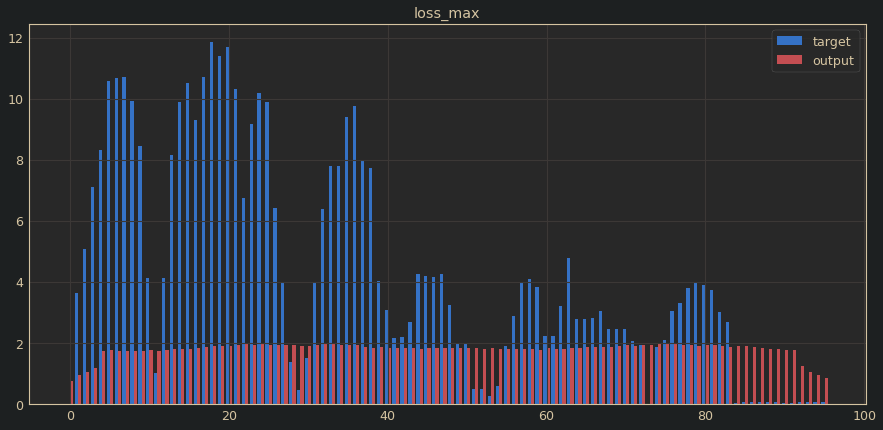

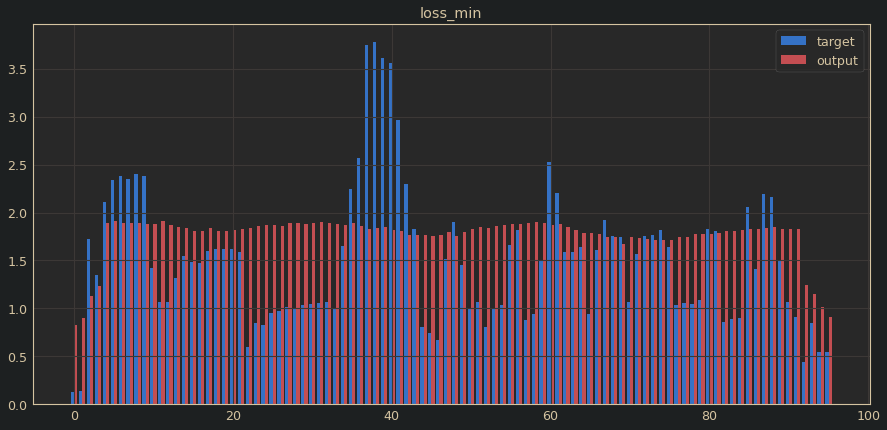


test_loss: 2.514


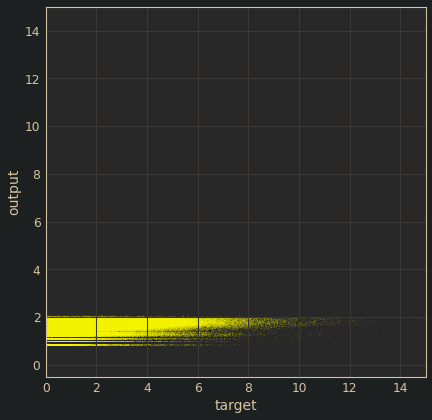

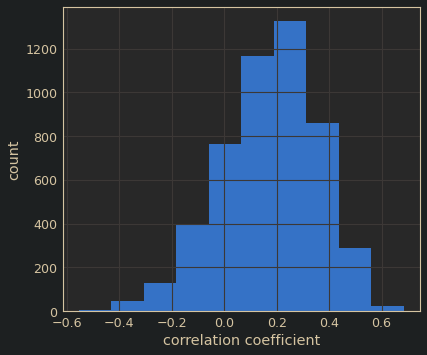

0.1742875204878881


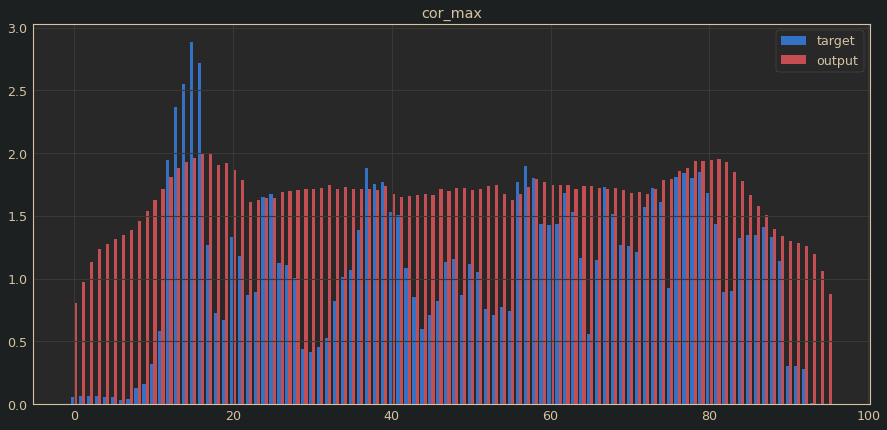

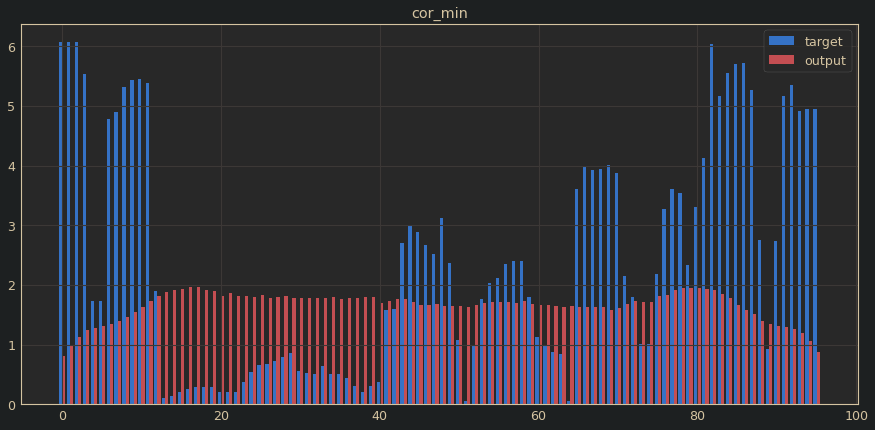

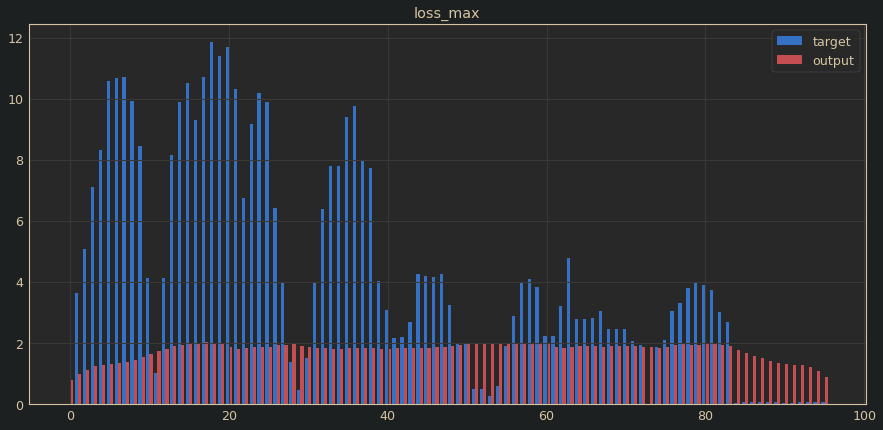

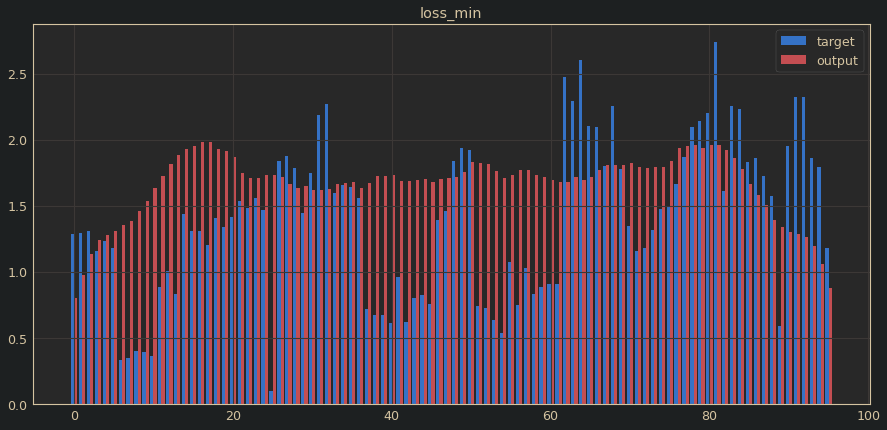


test_loss: 2.752


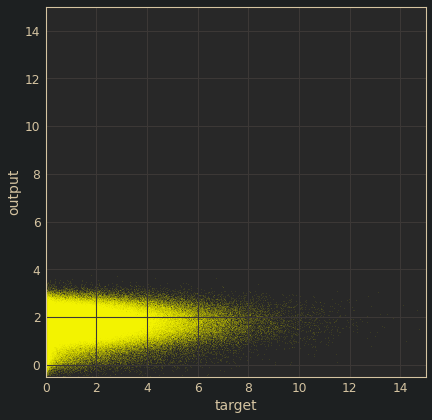

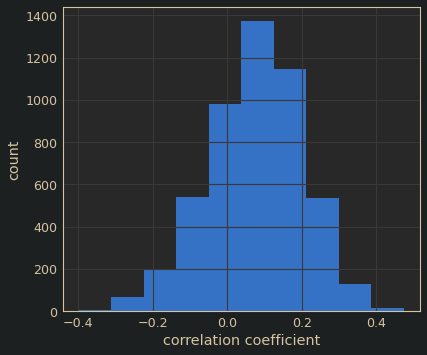

0.07658815208736171


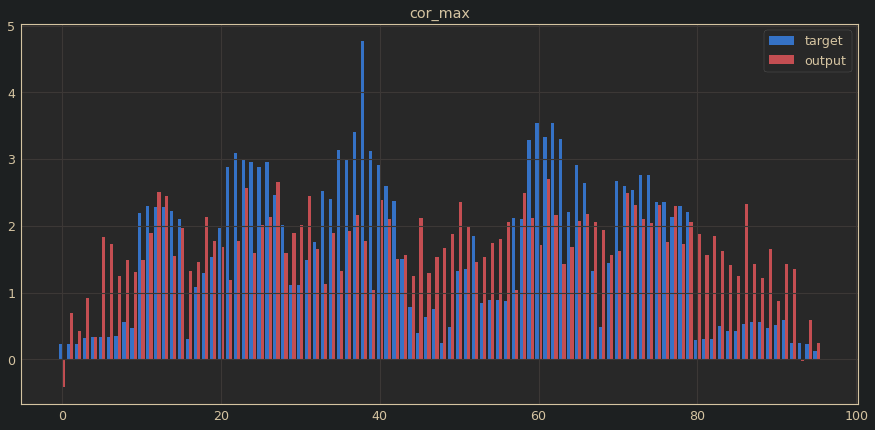

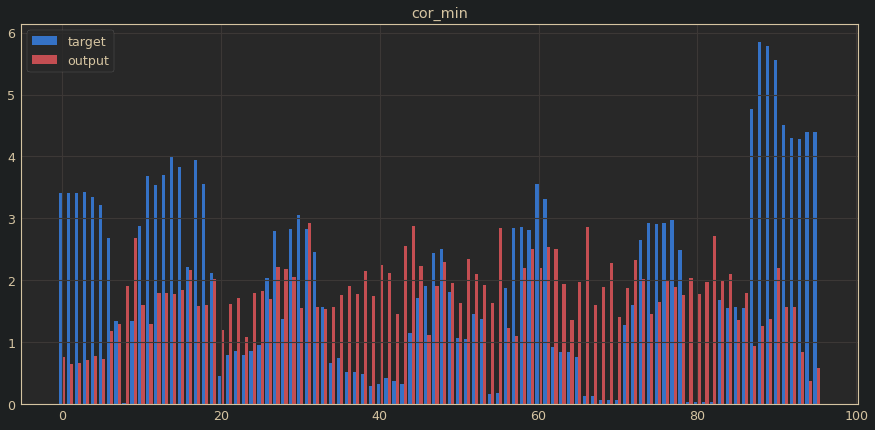

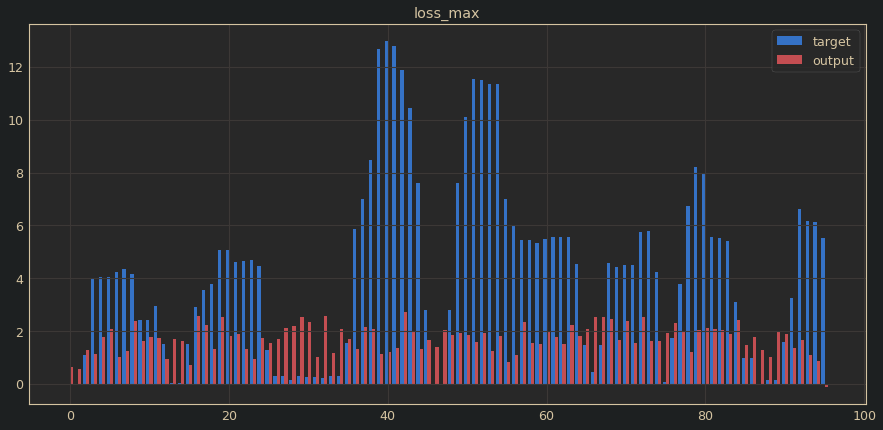

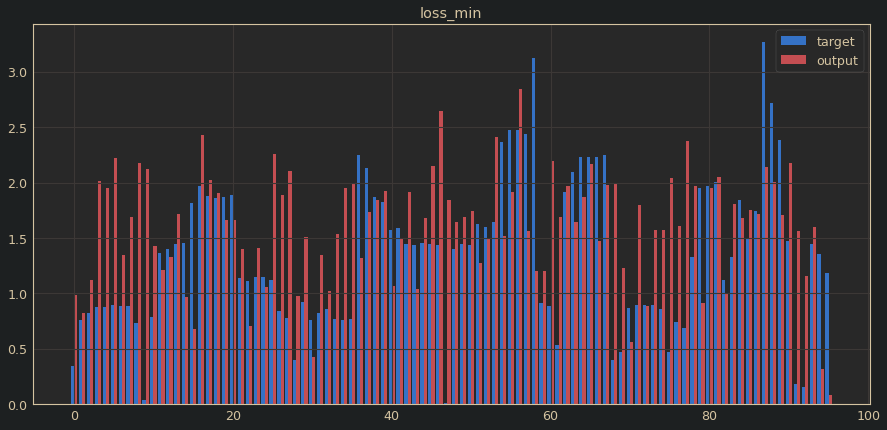


test_loss: 2.513


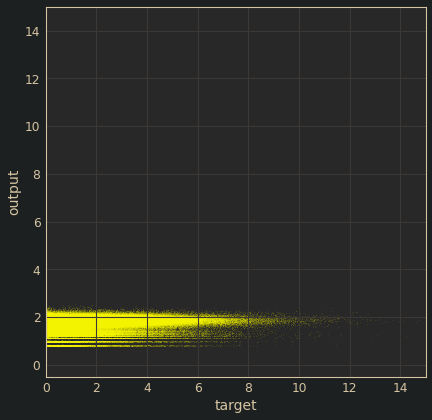

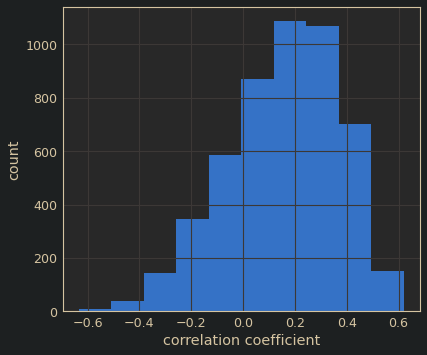

0.15800504030778484


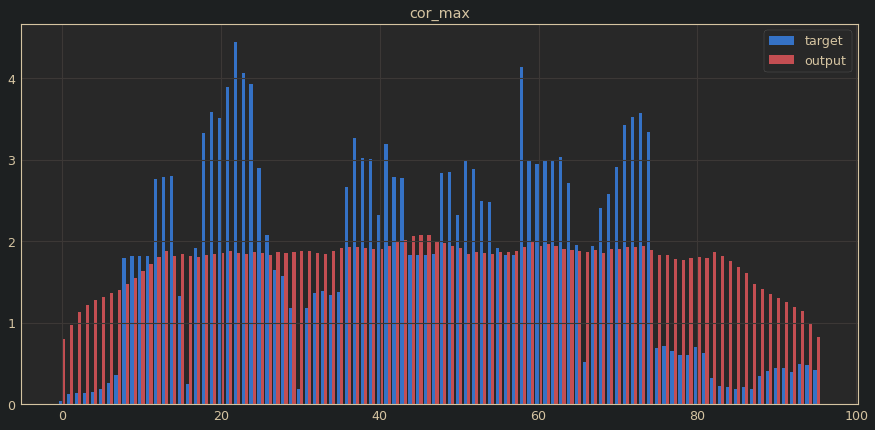

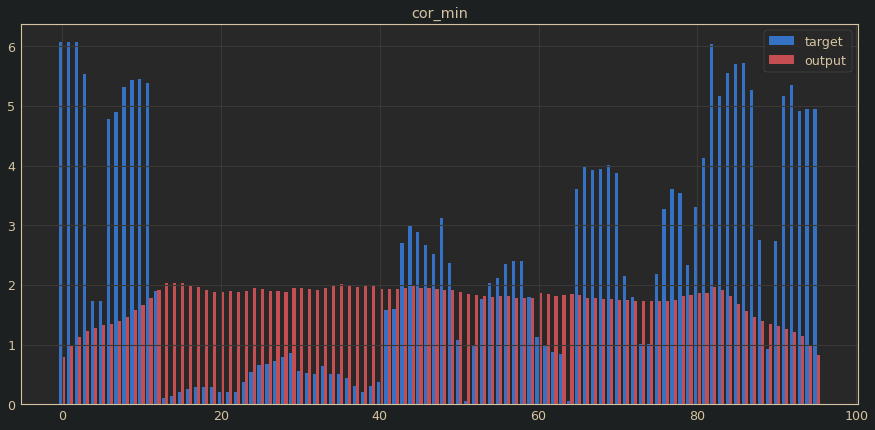

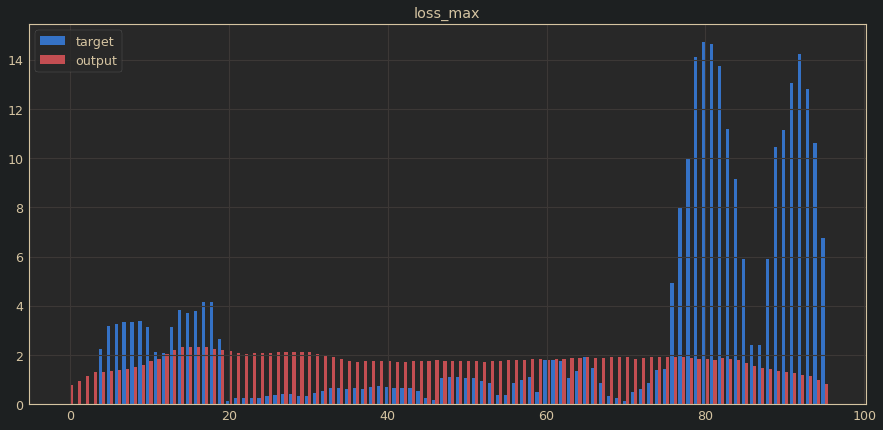

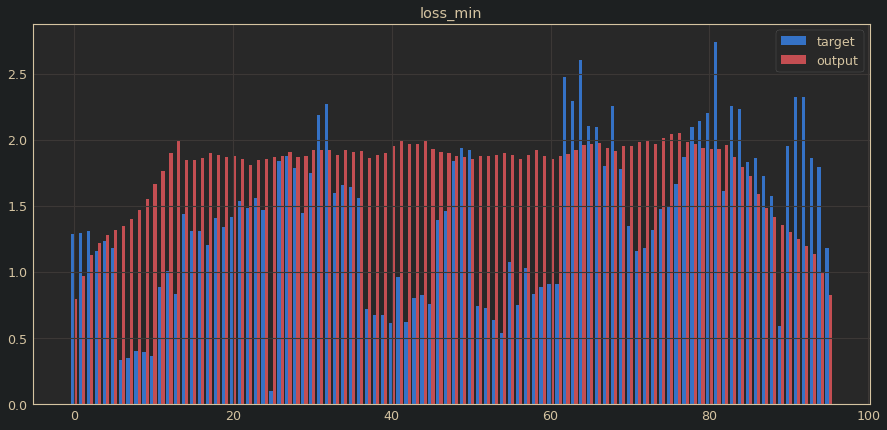


test_loss: 2.582


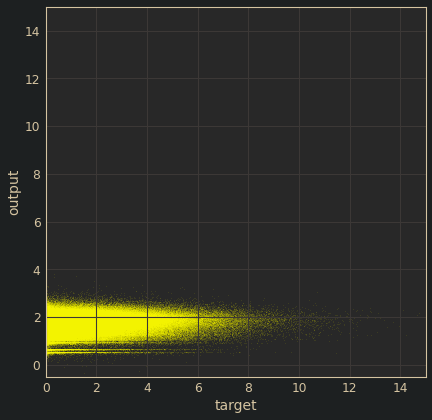

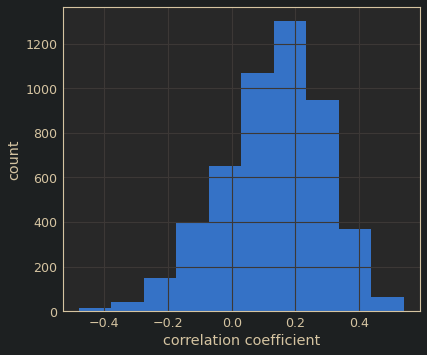

0.13038281143329886


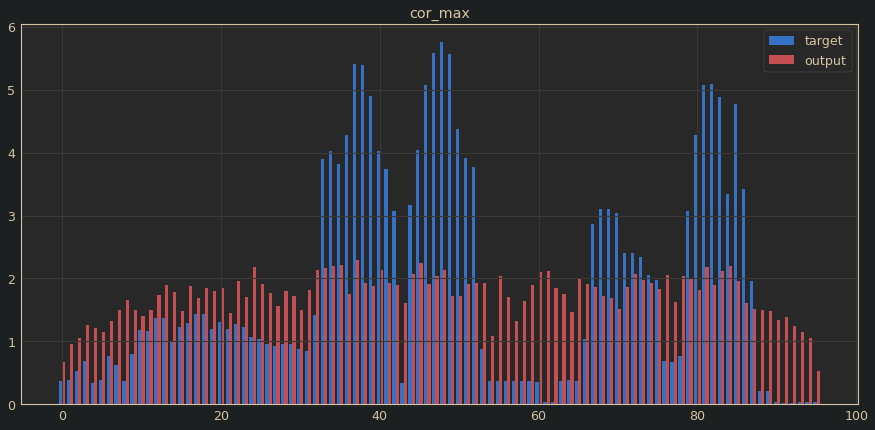

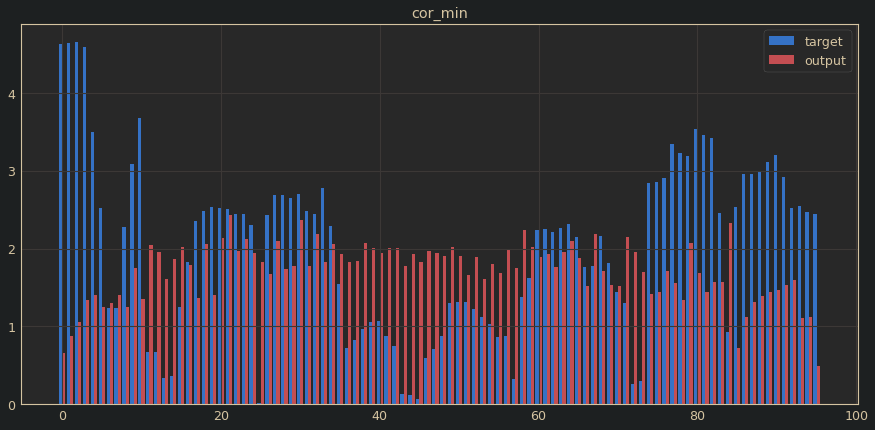

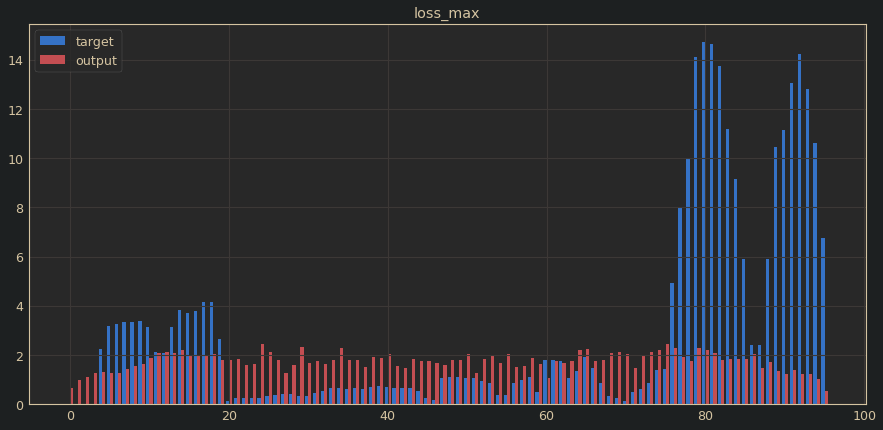

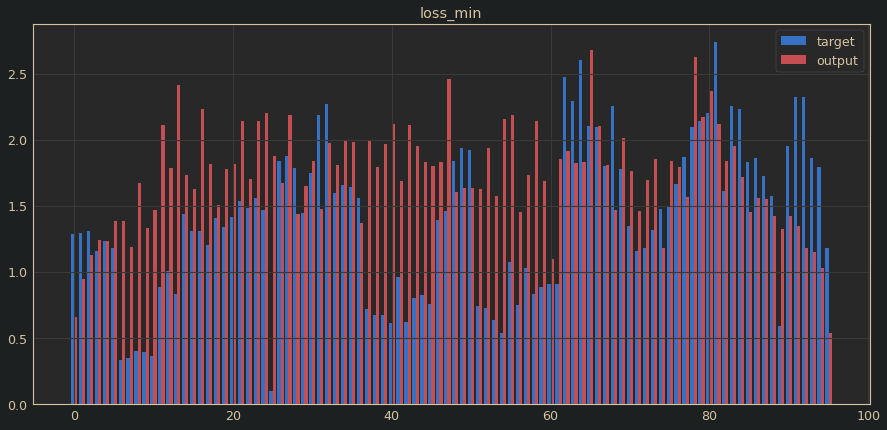


test_loss: 2.481


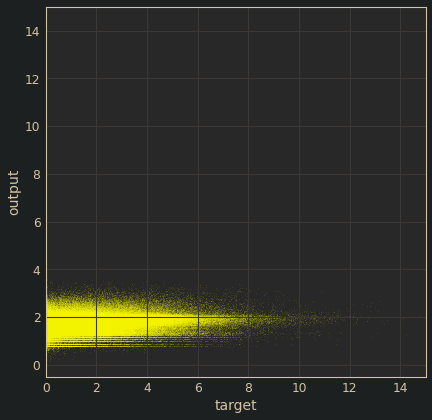

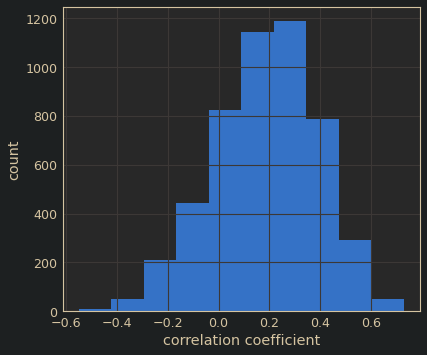

0.18513749328680446


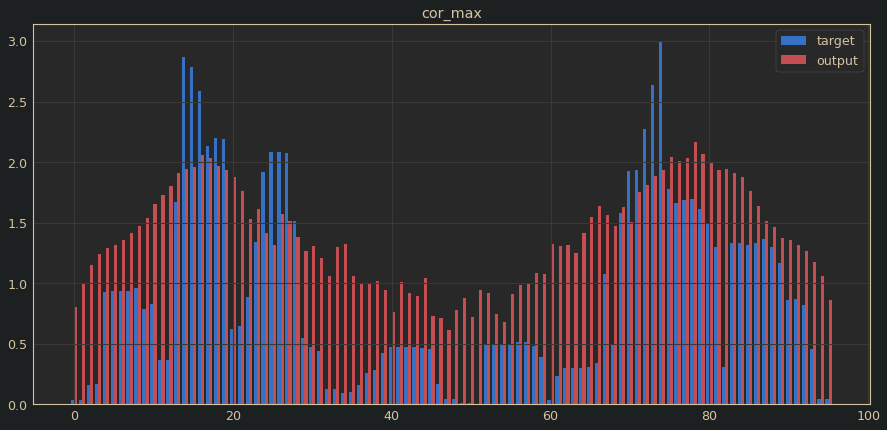

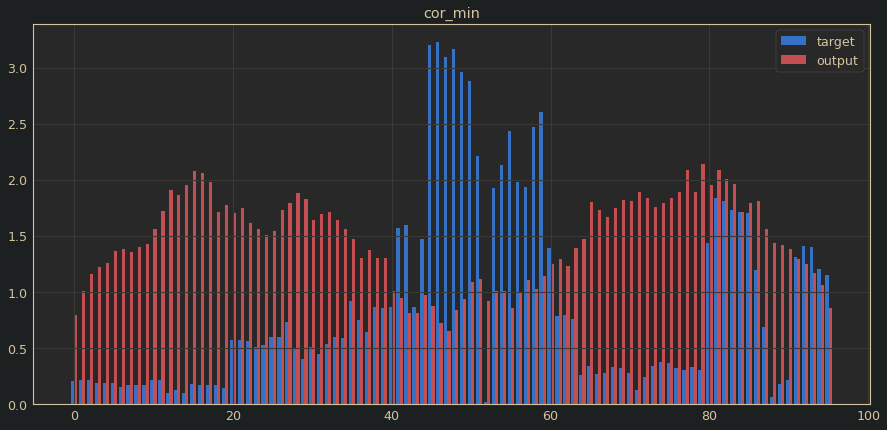

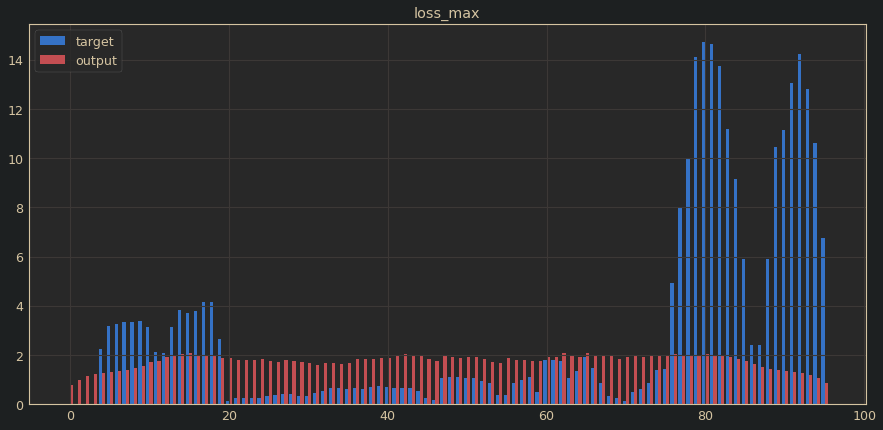

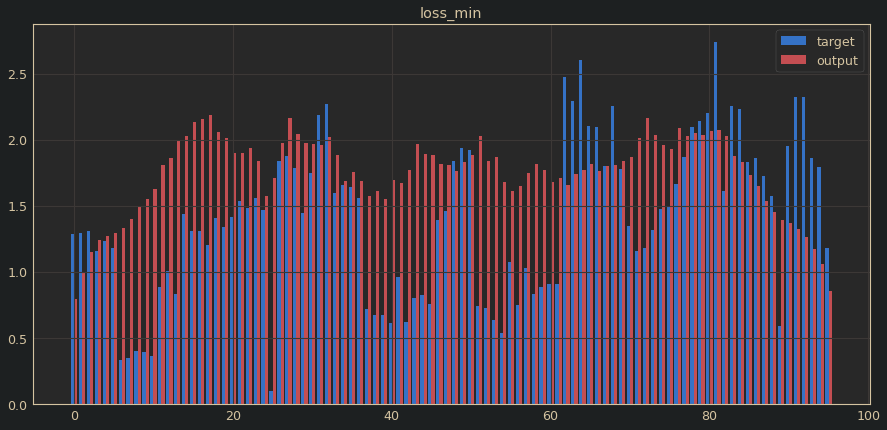


test_loss: 2.509


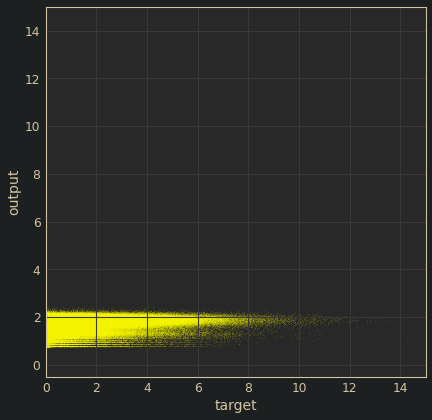

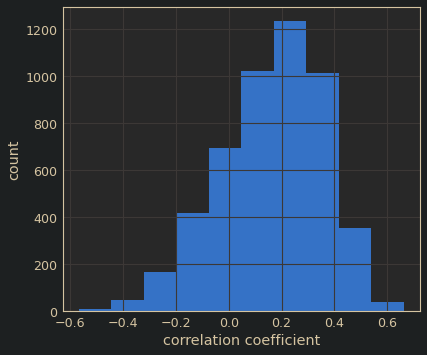

0.16471579246416426


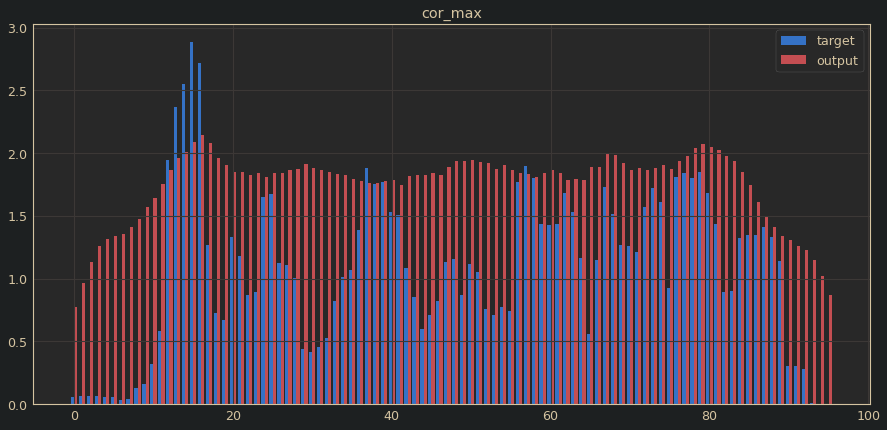

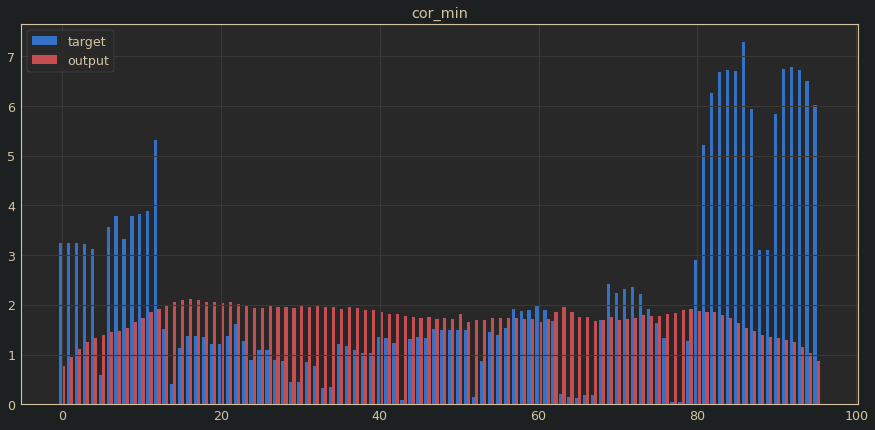

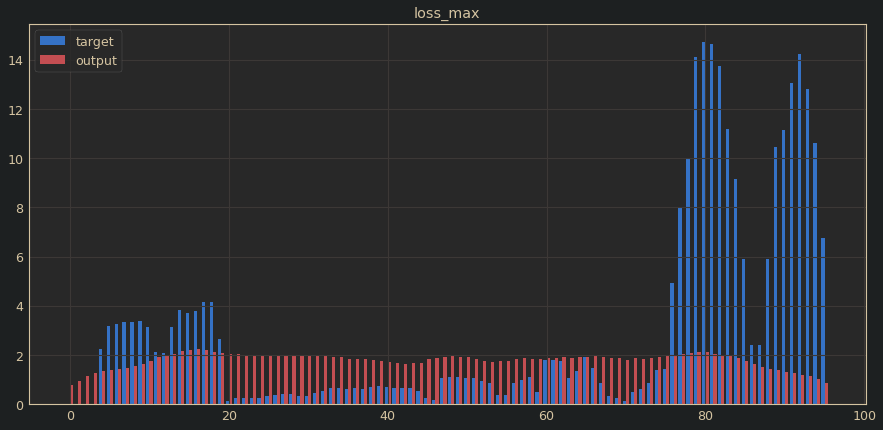

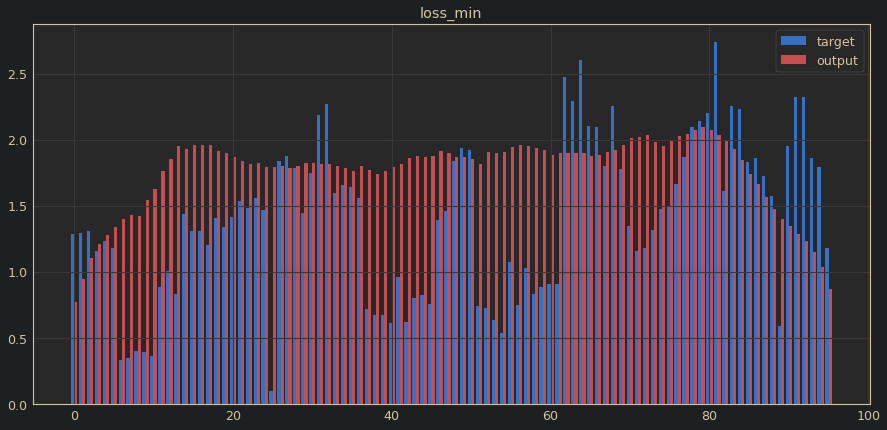


test_loss: 2.516


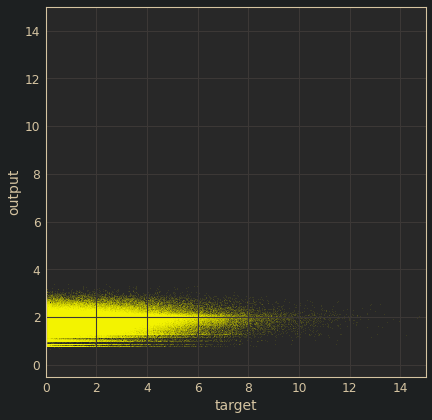

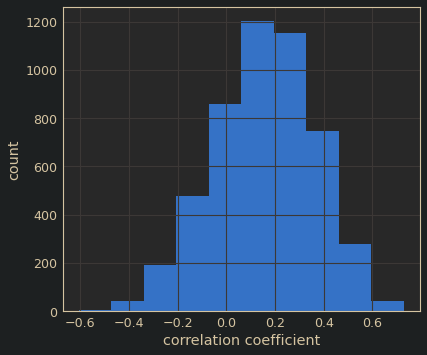

0.15636587979102246


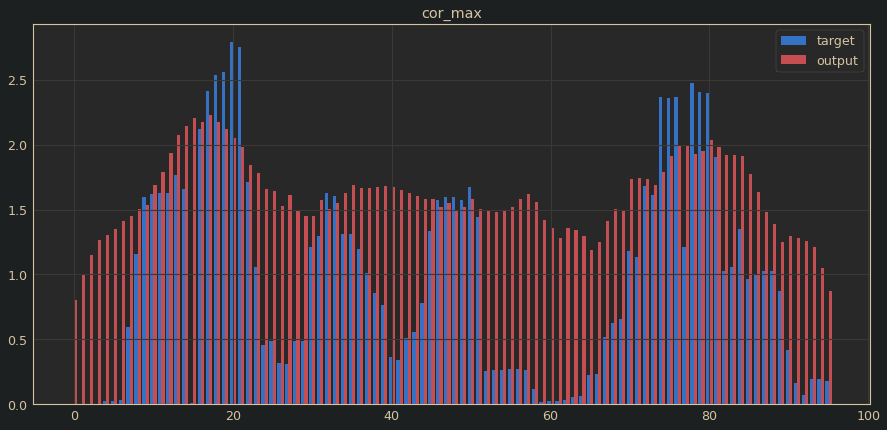

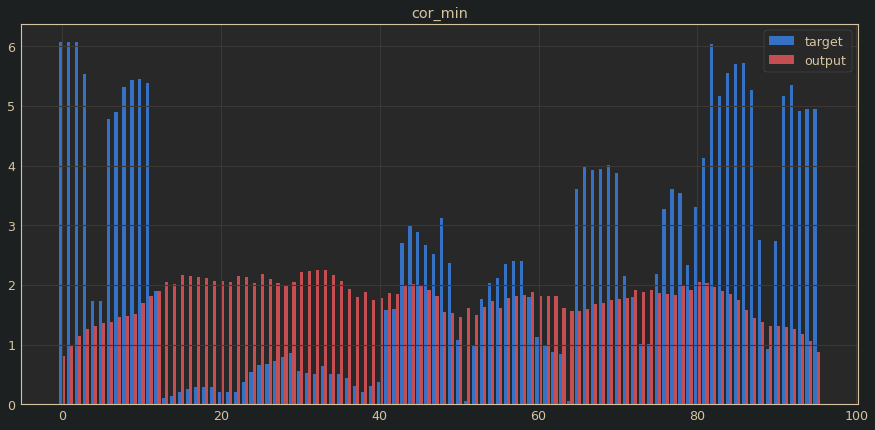

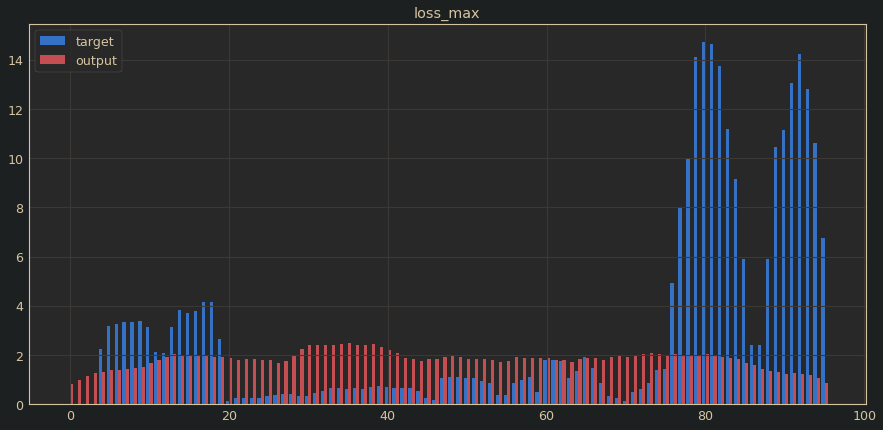

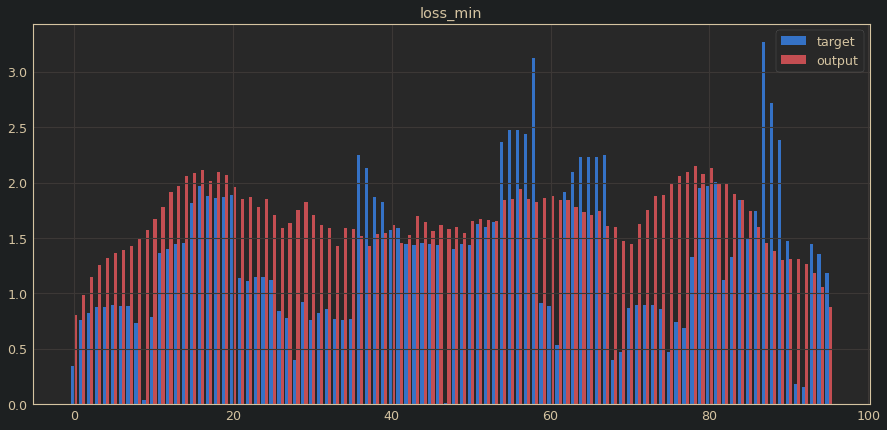


test_loss: 1.805


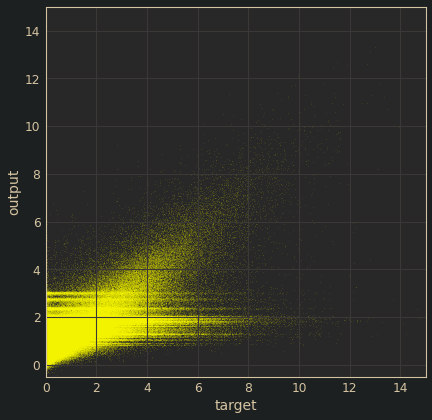

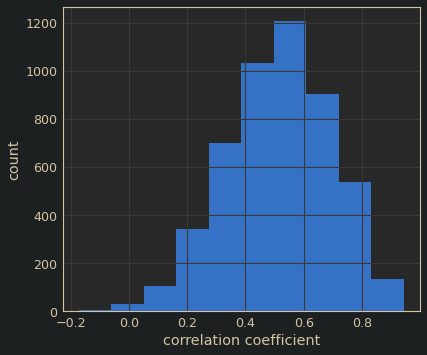

0.5154040684533567


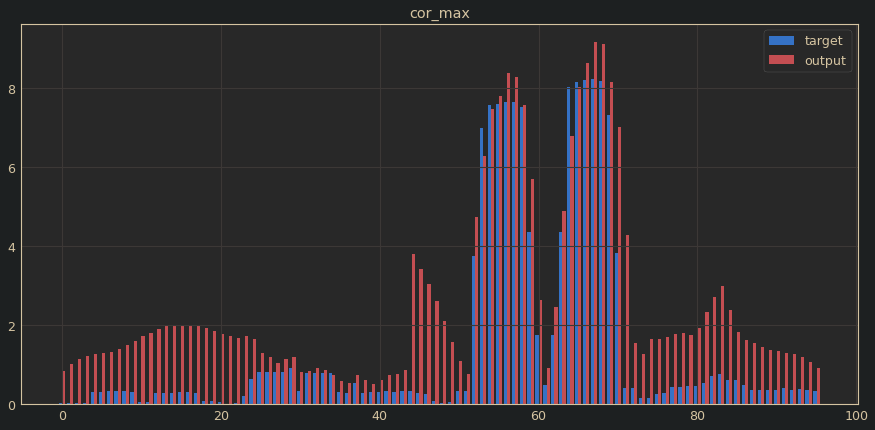

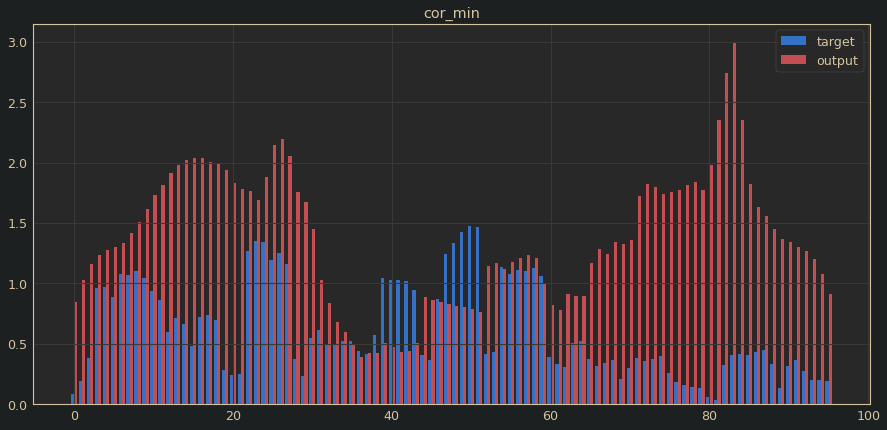

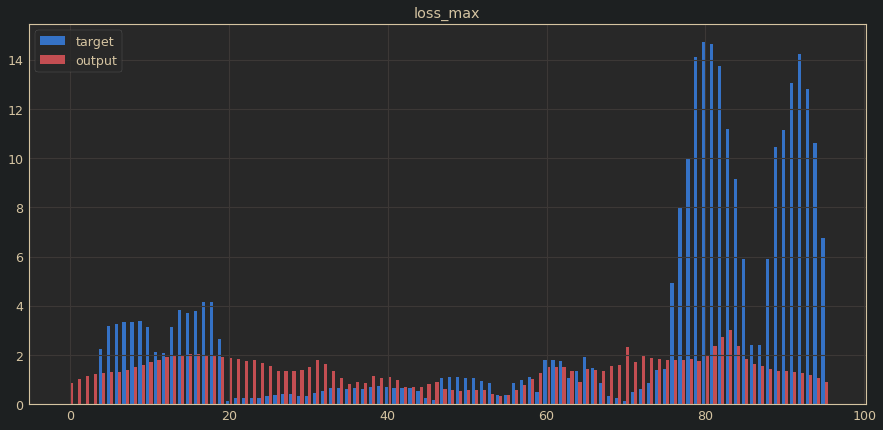

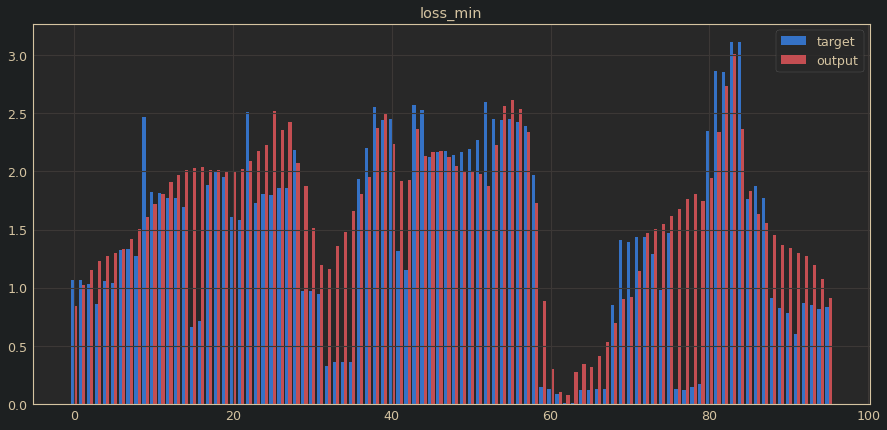


test_loss: 2.525


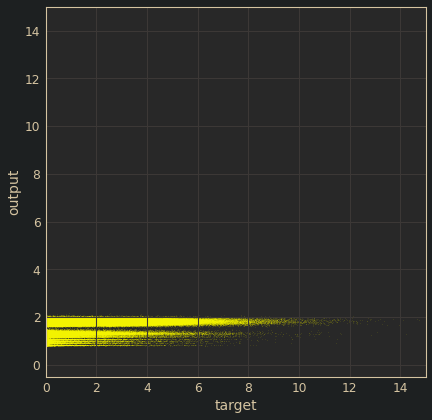

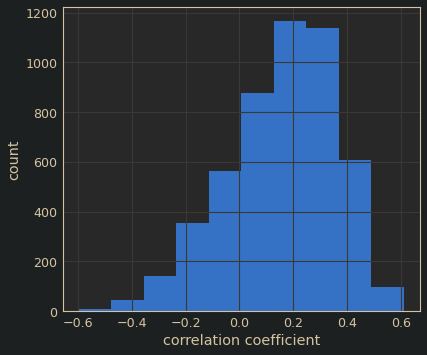

0.1579582462218109


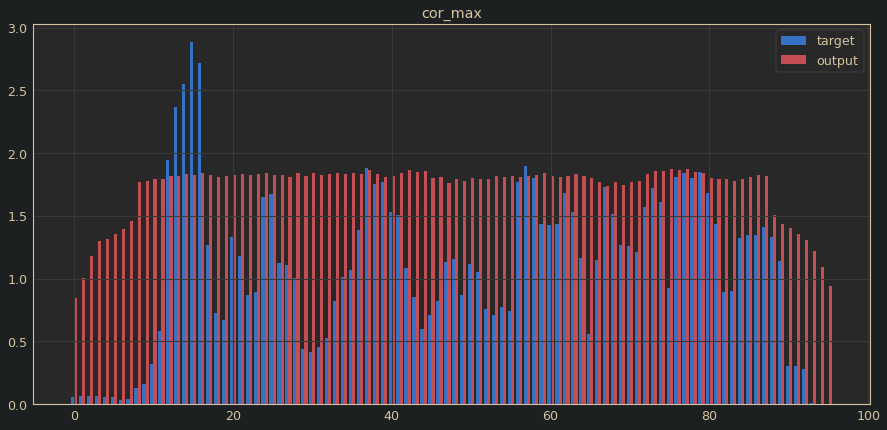

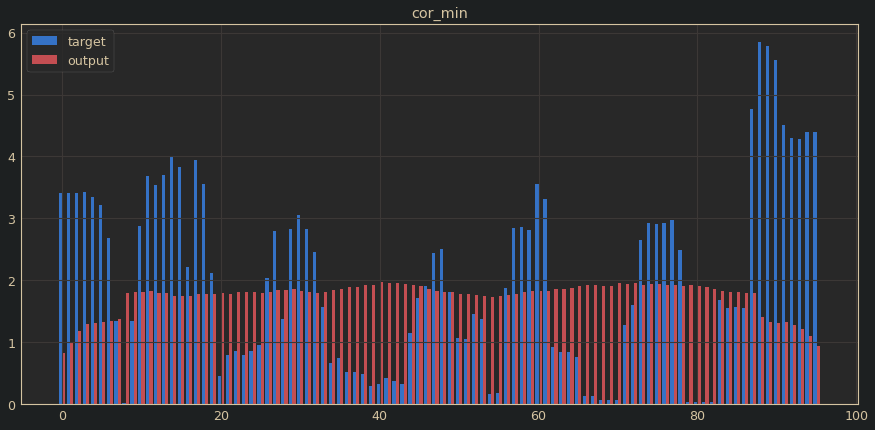

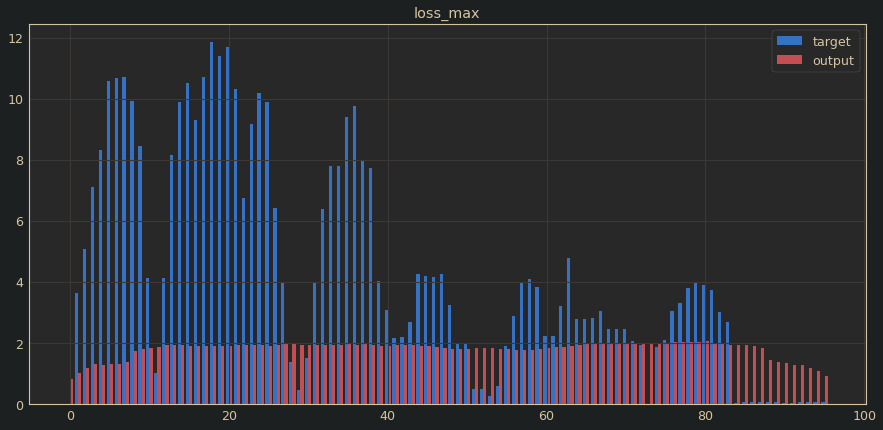

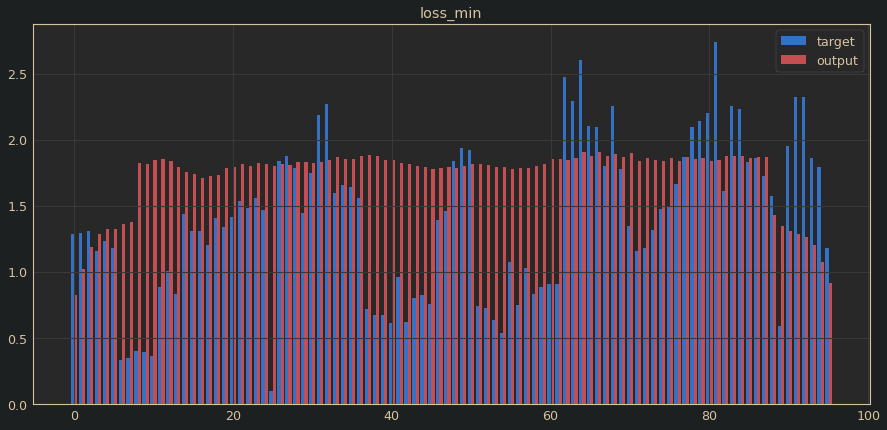

KeyboardInterrupt: 

In [11]:
datanumloss_list = []
datanumcor_list = []
listing = [1]

for abc in listing:
  prm = abc

  train_dataset = Dataset(input_train[0:300000], target_train[0:300000])
  test_dataset = Dataset(input_test[0:5000], target_test[0:5000])
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256,shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256,shuffle=True, num_workers=2)


trial = 100
study = optuna.create_study()
study.optimize(objective, n_trials=trial)

print(study.best_params)
print(study.best_value)

para_log = study.trials

In [12]:
print(study.best_params)
print(study.best_value)

{'num_layer': 8, 'num_filter_0': 176.0, 'num_filter_1': 144.0, 'num_filter_2': 32.0, 'num_filter_3': 128.0, 'num_filter_4': 80.0, 'num_filter_5': 176.0, 'num_filter_6': 160.0, 'num_filter_7': 160.0, 'kernel_size_0': 3.0, 'kernel_size_1': 7.0, 'kernel_size_2': 3.0, 'kernel_size_3': 9.0, 'kernel_size_4': 9.0, 'kernel_size_5': 9.0, 'kernel_size_6': 7.0, 'optimizer': 'rmsprop', 'weight_decay': 2.5522251898982784e-08}
1.8054915487766265


In [13]:
print(study.trials)

[FrozenTrial(number=0, value=2.544109284877777, datetime_start=datetime.datetime(2020, 10, 6, 15, 50, 18, 824448), datetime_complete=datetime.datetime(2020, 10, 6, 15, 52, 48, 782223), params={'num_layer': 1, 'num_filter_0': 16.0, 'optimizer': 'Adam', 'weight_decay': 2.1139478866698604e-06, 'adam_lr': 0.00021498564476654826}, distributions={'num_layer': IntUniformDistribution(high=10, low=1, step=1), 'num_filter_0': DiscreteUniformDistribution(high=192, low=16, q=16), 'optimizer': CategoricalDistribution(choices=('Adam', 'MomentumSGD', 'rmsprop')), 'weight_decay': LogUniformDistribution(high=0.001, low=1e-10), 'adam_lr': LogUniformDistribution(high=0.01, low=1e-07)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE), FrozenTrial(number=1, value=2.514294910430908, datetime_start=datetime.datetime(2020, 10, 6, 15, 52, 48, 782982), datetime_complete=datetime.datetime(2020, 10, 6, 16, 5, 27, 916923), params={'num_layer': 7, 'num_filter_0': 48.0,

In [ ]:
cor_max = []
cor_min = []
loss_max = []
loss_min = []
for i in range(1000):
  if (test_dataloader.dataset[np.argmax(cor_list)][0][0][i]==1):
    cor_max.append('A')
  elif (test_dataloader.dataset[np.argmax(cor_list)][0][1][i]==1):
    cor_max.append('U')
  elif (test_dataloader.dataset[np.argmax(cor_list)][0][2][i]==1):
    cor_max.append('G')
  elif (test_dataloader.dataset[np.argmax(cor_list)][0][3][i]==1):
    cor_max.append('C')

  if (test_dataloader.dataset[np.argmin(cor_list)][0][0][i]==1):
    cor_min.append('A')
  elif (test_dataloader.dataset[np.argmin(cor_list)][0][1][i]==1):
    cor_min.append('U')
  elif (test_dataloader.dataset[np.argmin(cor_list)][0][2][i]==1):
    cor_min.append('G')
  elif (test_dataloader.dataset[np.argmin(cor_list)][0][3][i]==1):
    cor_min.append('C')

  if (test_dataloader.dataset[np.argmax(loss_list)][0][0][i]==1):
    loss_max.append('A')
  elif (test_dataloader.dataset[np.argmax(loss_list)][0][1][i]==1):
    loss_max.append('U')
  elif (test_dataloader.dataset[np.argmax(loss_list)][0][2][i]==1):
    loss_max.append('G')
  elif (test_dataloader.dataset[np.argmax(loss_list)][0][3][i]==1):
    loss_max.append('C')

  if (test_dataloader.dataset[np.argmin(loss_list)][0][0][i]==1):
    loss_min.append('A')
  elif (test_dataloader.dataset[np.argmin(loss_list)][0][1][i]==1):
    loss_min.append('U')
  elif (test_dataloader.dataset[np.argmin(loss_list)][0][2][i]==1):
    loss_min.append('G')
  elif (test_dataloader.dataset[np.argmin(loss_list)][0][3][i]==1):
    loss_min.append('C')
print('cor_max', ''.join(cor_max))
print('cor_min', ''.join(cor_min))
print('loss_max', ''.join(loss_max))
print('loss_min', ''.join(loss_min))